In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

df = pd.read_parquet('../../time-use-survey-2024/clean/per-tus-2024.parquet')
hdf = pd.read_parquet('../../time-use-survey-2024/clean/hh-tus-2024.parquet')

In [2]:
import yaml

with open('nic-white-collar.yaml', 'r') as fin:
    NIC = yaml.safe_load(fin).keys()

# Salaried people
df = df[df['usual_principal_activity_status'] == 'worked as regular salaried/ wage employee']
# Of the right age
df = df[df['age'] >= 15]
df = df[df['age'] <= 60]
df.dropna(subset=['activity_code'], inplace=True)

# Get time spent
def get_time_spent(time_from, time_to):
    if time_from == time_to:
        return 24 * 60
    start_hour, start_min = map(int, time_from.split(':'))
    end_hour, end_min = map(int, time_to.split(':'))
    minutes = end_hour * 60 + end_min - start_hour * 60 - start_min
    if minutes > 0:
        return minutes
    return 24 * 60 + minutes

df['ts'] = df[['time_from', 'time_to']].apply(lambda x: get_time_spent(**x), axis=1)

# Get personal_info columns
cols = ['sector', 'gender', 'age', 'marital_status', 'education', 'mult', 'nic_2008_principal_activity']
xdf = df.groupby(df.index)[cols].first()

# Summarize time spent on activity categories
df['ACT_CODE'] = df['activity_code'].astype(str).str.get(0).astype(int)
ydf = df.groupby([df.index, 'ACT_CODE'])['ts'].sum().unstack().fillna(value=0)
ydf.columns = ACT_COLS = [f'ACT_{i}' for i in range(1, 10)]

pdf = pd.concat([xdf, ydf], axis=1)
pdf.index = pd.MultiIndex.from_tuples(pdf.index, names=df.index.names)

# Combine this with household info
hh_info = hdf.loc[pdf.index.droplevel(-1).drop_duplicates(),
                  ['religion', 'social_group', 'total_monthly_ce',
                   'energy_cooking', 'energy_lighting', 'washing_type',
                   'sweeping_type', 'dwelling_unit', 'dwelling_unit_structure_type']]
pdf = pdf.reset_index(-1).merge(
    hh_info, how='outer', left_index=True, right_index=True
).reset_index().set_index(pdf.index.names, verify_integrity=True)

pdf['age-group'] = pd.cut(pdf['age'], [10, 20, 30, 40, 50, 60], labels=['<= 20', '20-30', '30-40', '40-50', '50-60'], ordered=True)
pdf['qrt'] = pd.qcut(pdf['total_monthly_ce'], 4, labels=[1, 2, 3, 4])

wc = pdf[pdf['nic_2008_principal_activity'].isin(NIC)]

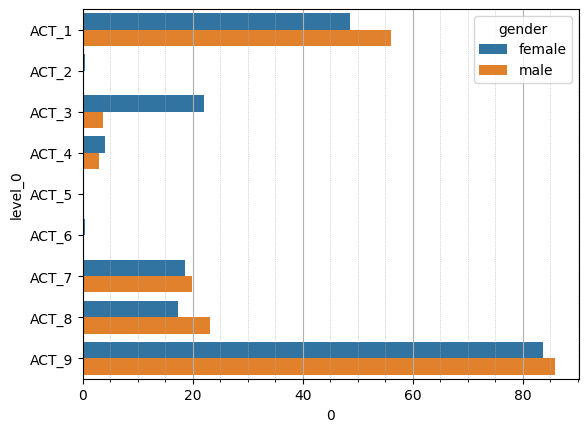

In [35]:
# Time spent by activity group
labels = {
    "ACT_1": "Employment / Paid Work",
    "ACT_2": "Production of Goods for Self-Consumption",
    "ACT_3": "Unpaid Domestic Services for Family",
    "ACT_4": "Unpaid Caregiving for Family",
    "ACT_5": "Unpaid Volunteering / Trainee",
    "ACT_6": "Learning",
    "ACT_7": "Socializing / Religious Practice / Community",
    "ACT_8": "Culture / Leisure / Mass-media / Sports",
    "ACT_9": "Self-Care & Maintenance"
}
ts = wc.groupby('gender').apply(
    lambda x: pd.Series((x[ACT_COLS].values * x['mult'].values.reshape(-1, 1)).sum(axis=0) / x['mult'].sum(), index=ACT_COLS)
)
ts = (ts * 7 / 60).unstack().reset_index()
ts = ts[ts['gender'] != 'transgender']
ax = sns.barplot(ts, x=0, y='level_0', hue='gender')
ax.xaxis.grid()
ax.xaxis.minorticks_on()
ax.xaxis.grid(which='minor', linestyle=':', linewidth=0.5)

In [40]:
ts

,level_0,gender,0
0,ACT_1,female,48.636194
1,ACT_1,male,56.000776
3,ACT_2,female,0.461384
4,ACT_2,male,0.239327
6,ACT_3,female,21.969160
7,ACT_3,male,3.684698
9,ACT_4,female,3.986732
10,ACT_4,male,2.974217
12,ACT_5,female,0.181459
13,ACT_5,male,0.126986


In [51]:
168 - (83.6 + 90 + 12.5)

-18.099999999999994

In [44]:
wc.groupby('gender')['mult'].sum() / wc['mult'].sum()

gender
female         0.297158
male           0.702495
transgender    0.000347
Name: mult, dtype: float64

In [4]:
ts.columns = ['act', 'gender', 'time_spent']

In [5]:
ts['act'] = ts['act'].replace(labels)

In [33]:
import warnings
warnings.simplefilter('ignore')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

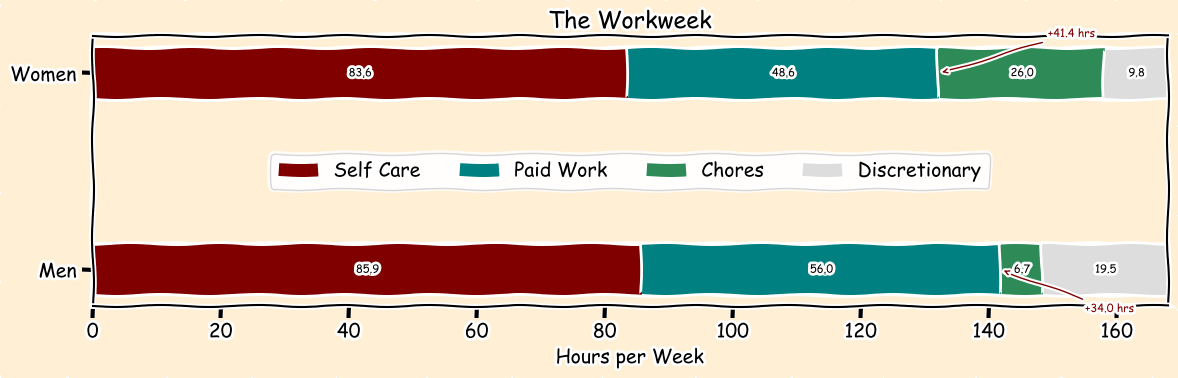

In [34]:
import matplotlib.pyplot as plt

# Define activity groups
self_care = ["Self-Care & Maintenance"]
paid_work = ["Employment / Paid Work"]
chores = [
    "Unpaid Domestic Services for Family",
    "Unpaid Caregiving for Family"
]

def compute_groups(ts, gender):
    df = ts[ts['gender'] == gender]
    total = df.groupby("act")["time_spent"].sum()
    self_care_time = total[self_care].sum()
    paid_work_time = total[paid_work].sum()
    chores_time = total[chores].sum()
    discretionary_time = 168 - (self_care_time + paid_work_time + chores_time)
    return [self_care_time, paid_work_time, chores_time, discretionary_time]

female_times = compute_groups(ts, "female")
male_times = compute_groups(ts, "male")

# Plot
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12, 4))
    fig.patch.set_facecolor("papayawhip")
    ax.set_facecolor("papayawhip")

    labels = ['Self Care', 'Paid Work', 'Chores', 'Discretionary']
    bar_height = 0.25
    y_pos = [1, 0]  # Women on top

    ax.barh(1, sum(female_times), color='lightgray', height=bar_height)
    ax.barh(0, sum(male_times), color='lightgray', height=bar_height)

    left_f, left_m = 0, 0
    colors = ['maroon', 'teal', 'seagreen', '#dddddd']

    for i, (f, m) in enumerate(zip(female_times, male_times)):
        # Women
        ax.barh(1, f, left=left_f, label=labels[i], color=colors[i], height=bar_height)
        ax.text(left_f + f / 2, 1, f"{f:.1f}", va='center', ha='center', fontsize=8, color='black')

        # Men
        ax.barh(0, m, left=left_m, color=colors[i], height=bar_height)
        ax.text(left_m + m / 2, 0, f"{m:.1f}", va='center', ha='center', fontsize=8, color='black')

        left_f += f
        left_m += m
        

    ax.set_yticks(y_pos)
    ax.set_yticklabels(['Women', 'Men'])
    ax.set_xlim(0, 168)
    ax.set_xlabel("Hours per Week")
    ax.set_title("The Workweek")
    ax.legend(loc='center', ncol=4)

    
    plt.tight_layout()


In [19]:
xdf = df.loc[wc.index]
TIME = xdf.groupby([xdf.index, 'activity_code'])['ts'].sum().unstack().fillna(value=0)

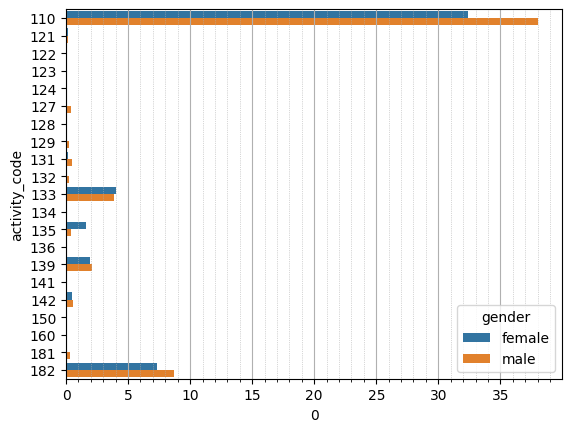

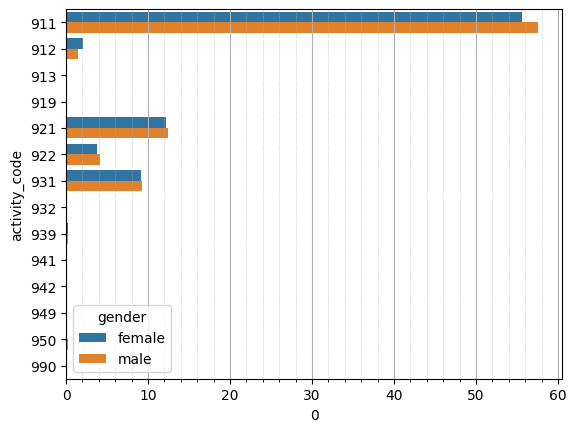

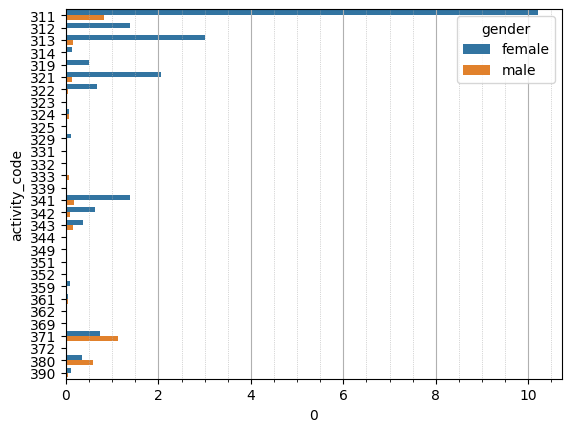

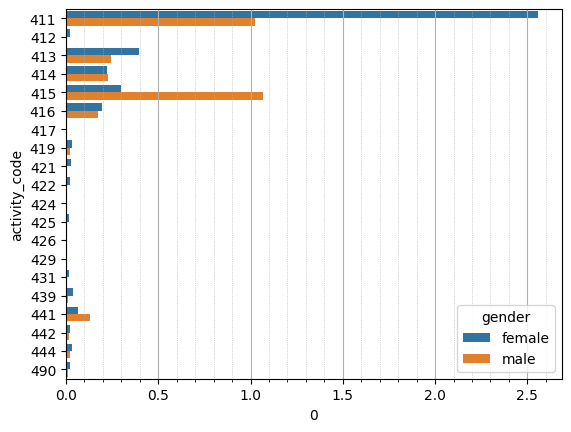

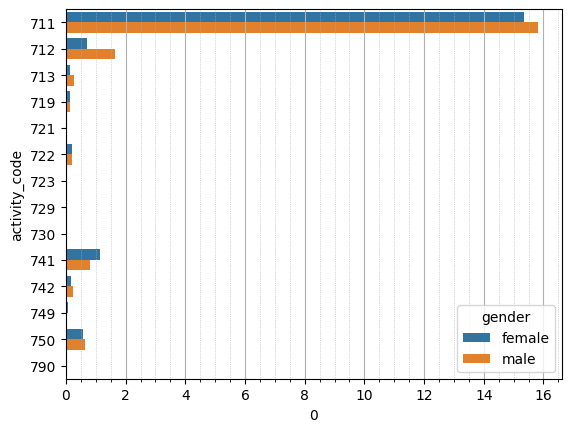

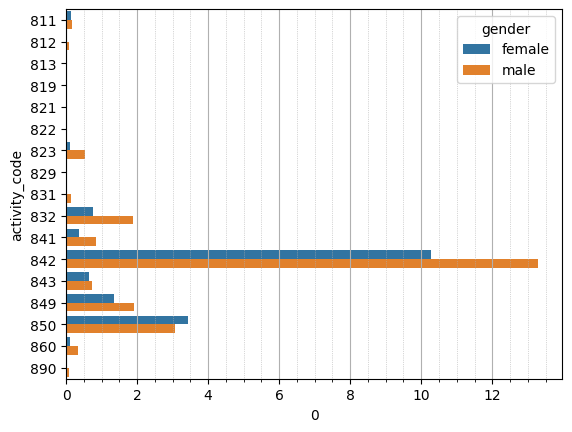

In [20]:
for cat in [1, 9, 3, 4, 7, 8]:
    ts = TIME[[c for c in TIME.columns if str(c).startswith(f'{cat}')]].copy()
    cols = ts.columns
    ts[['gender', 'mult']] = wc.loc[ts.index, ["gender", "mult"]]
    foo = ts.groupby('gender').apply(lambda x: pd.Series((x[cols].values * x['mult'].values.reshape(-1, 1)).sum(axis=0) / x['mult'].sum()))
    foo.columns = cols.astype(int).astype(str)
    foo = foo.unstack().reset_index()
    foo[0] = foo[0] * 7 / 60
    foo = foo[foo['gender'] != 'transgender']
    
    plt.figure()
    sns.barplot(foo, x=0, y="activity_code", hue="gender")
    xax = plt.gca().xaxis
    xax.grid()
    xax.minorticks_on()
    xax.grid(which='minor', linestyle=':', linewidth=0.5)

In [47]:
men = wc[wc['gender'] == 'male']
women = wc[wc['gender'] == 'female']

In [54]:
# Cooking vs meta
wc['cooking_time'] = TIME.loc[wc.index, 311]
men = wc[wc['gender'] == 'male']
women = wc[wc['gender'] == 'female']

/tmp/ipykernel_6150/3180078540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wc['cooking_time'] = TIME.loc[wc.index, 311]


In [55]:
men.columns

Index(['sector', 'gender', 'age', 'marital_status', 'education', 'mult',
       'nic_2008_principal_activity', 'ACT_1', 'ACT_2', 'ACT_3', 'ACT_4',
       'ACT_5', 'ACT_6', 'ACT_7', 'ACT_8', 'ACT_9', 'religion', 'social_group',
       'total_monthly_ce', 'energy_cooking', 'energy_lighting', 'washing_type',
       'sweeping_type', 'dwelling_unit', 'dwelling_unit_structure_type',
       'age-group', 'qrt', 'non_work_non_selfcare', 'cooking_time'],
      dtype='object')

In [166]:
wc['nothing'] = TIME.loc[wc.index, 850]
men = wc[wc['gender'] == 'male']
women = wc[wc['gender'] == 'female']

/tmp/ipykernel_6150/860823102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wc['nothing'] = TIME.loc[wc.index, 850]


In [174]:
(men.groupby('qrt').apply(lambda x: (x['nothing'] * x['mult']).sum() / x['mult'].sum()) * 7 / 60).sort_index()

qrt
1    3.362693
2    3.026957
3    3.250363
4    2.855212
dtype: float64

In [175]:
(women.groupby('qrt').apply(lambda x: (x['nothing'] * x['mult']).sum() / x['mult'].sum()) * 7 / 60).sort_index()

qrt
1    3.114080
2    3.864267
3    3.590979
4    3.313492
dtype: float64

In [176]:
ts[]

activity_code,811.0,812.0,813.0,819.0,821.0,822.0,823.0,829.0,831.0,832.0,841.0,842.0,843.0,849.0,850.0,860.0,890.0,gender,mult
"(30010, 2, 3)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,208857
"(30014, 2, 5)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,female,196571
"(30014, 13, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,male,196571
"(30015, 1, 3)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,male,221786
"(30015, 8, 7)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,female,221786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(66997, 11, 4)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,90.0,0.0,0.0,0.0,female,233493
"(66997, 14, 1)",0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0,male,233493
"(66997, 14, 6)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,60.0,0.0,0.0,0.0,female,233493
"(66998, 10, 2)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,female,238550
